# ISLP - Chapter 5 - Exercise 8
### Author: pzuehlke

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

__8 (a):__ Here $ n $ (the number of observations) is $ 100 $ since it is
determined by the the value of `size`, while $ p $ (the number of predictors) is
equal to $ 2 $, because in the model $ y $ depends on $ x $ and $ x^2 $. The
true model in equation form reads:
$$
Y = X - 2X^2 + \varepsilon
$$
where $ \varepsilon $ is drawn from a standard normal distribution.

In [2]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

__8 (b):__ It is clear from the scatterplot that the relationship between $ x $
and $ y $ is linear; in fact, it looks like $ y $ is approximately a quadratic
function of $ x $.

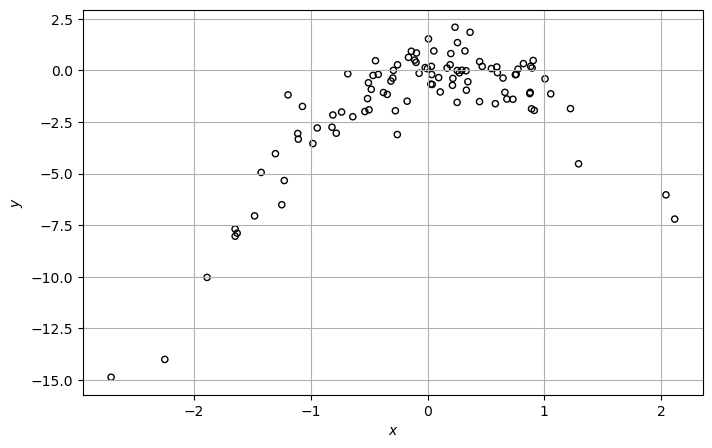

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(x, y, color="black", facecolor="none", s=20)
ax.set_xlabel("$ x $")
ax.set_ylabel("$ y $")
ax.grid(True)
plt.show()

__8 (c):__ I'm not sure about which role the authors intended for the
random seed. If the seed is meant to permute data before it is split
into train/test subsets, then it makes no difference because LOOCV is
deterministic: for each datapoint $ P_i = (X_i, y_i) $, it trains the model on
its complement, computes the error at $ P_i $ and then takes the mean. However,
if the authors meant for the random seed to control the simulated data $ x $ and
$ y $, then by varying the seed we would obtain different datasets and hence
different LOOCV error estimates. An example is given in item (d).

In [10]:
def compute_loocv_error(X, y, d):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X.reshape(-1, 1))

    loo = LeaveOneOut()
    MSE_scores = []

    for train_idx, test_idx in loo.split(X_poly):
        X_train, X_test = X_poly[train_idx], X_poly[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = LinearRegression()
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        MSE_scores.append(mean_squared_error(y_test, prediction))

    return np.mean(MSE_scores)

In [11]:
loocv_errors = []
degrees = [1, 2, 3, 4]
for d in degrees:
    error = compute_loocv_error(x, y, d)
    loocv_errors.append(error)
    print(f"Maximum degree: {d}\t LOOCV estimate for the MSE: {error:.4f}")

Maximum degree: 1	 LOOCV estimate for the MSE: 6.6330
Maximum degree: 2	 LOOCV estimate for the MSE: 1.1229
Maximum degree: 3	 LOOCV estimate for the MSE: 1.3018
Maximum degree: 4	 LOOCV estimate for the MSE: 1.3324


__8 (d):__ By modifying the seed and thus varying the data, the LOOCV estimates
for the mean squared error become different. Even though the linear model still
has the highest MSE by far, now the cubic and quartic models have a slightly
better MSE than the quadratic model.

In [13]:
rng = np.random.default_rng(2)  # different seed
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

# Rest of the code is the same:
loocv_errors = []
degrees = [1, 2, 3, 4]
for d in degrees:
    error = compute_loocv_error(x, y, d)
    loocv_errors.append(error)
    print(f"Maximum degree: {d}\t LOOCV estimate for the MSE: {error:.4f}")

Maximum degree: 1	 LOOCV estimate for the MSE: 7.5606
Maximum degree: 2	 LOOCV estimate for the MSE: 0.9840
Maximum degree: 3	 LOOCV estimate for the MSE: 0.9682
Maximum degree: 4	 LOOCV estimate for the MSE: 0.9660


__8 (e):__ The model that had the smallest LOOCV error was the quadratic model,
which is reassuring, since the data were simulated using a degree $ 2 $
polynomial on $ x $. The degree $ 1 $ model is too biased, and the higher-degree
models are overfitting the data.

__8 (f):__ The coefficients and the respective standard errors for each model
are presented below. There are several interesting things to note here:
* In the degree $ 1 $ model, both coefficients (the intercept and the
  coefficient of $ x $) are statistically significant, even though this model is
  misspecified.
* In the degree $ 2 $ model, the intercept is no longer statistically
  significant, while the other two coefficients are highly significant. This
  aligns well with the true model used to generate the data.
* Similarly, in the cubic and quartic models, the estimate for the
  intercept is also statistically insignificant, as is the estimate for the
  cubic term, while the degree $ 4 $ term has a $ p $-value of $ 2.31\% $. 

Perhaps the only unexpected result is that the intercept becomes
significant in the degree $ 1 $ model, to compensate for its high bias. All in
all, the results are quite consistent with the fact that the true model is quadratic
and has intercept equal to zero. The former conclusion is corroborated by our
discussion above about the estimated MSE for each model, obtained using LOOCV.

We will `statsmodels` below to be able to call the `summary` of the model, which
automatically computes the $ p $-values associated to each coefficient.

In [14]:
def fit_polynomial_model(X, y, d):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    model = sm.OLS(y, X_poly)
    results = model.fit()
    return results

In [15]:
degrees = [1, 2, 3, 4]
for d in degrees:
    results = fit_polynomial_model(x, y, d)
    print(results.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8158      0.265     -6.857      0.000      -2.341      -1.290
x1             1.1860      0.278      4.261      0.000       0.634       1.738
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0572      0.121     -0.474      0.637      -0.297       0.183
x1             1.1121      0.103     10.791      0.000       0.908       1.317
x2            -1.9436      0.078    -24.870      0.000      -2.099      -1.788
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0402      0.121     -0.333      0.740      -0.280       0.200
x1             1.3206      0.178      7.426      0.0